<a href="https://colab.research.google.com/github/lebrice/IFT6135/blob/master/A1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!/usr/bin/python3

"""
IFT 6135 - Representation Learning Assignment #1

Arnold Kokoroko - 20142304
Fabrice Normandin - 20142128 
Jerome Parent-Lévesque - 20143161

Github Repository: https://github.com/lebrice/IFT6135
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from itertools import islice
from enum import Enum

# we use the neat utility from tensorflow-keras to load the dataset in one line (rather than by using the download.py script.)
from tensorflow.keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

SIGMOID = "SIGMOID"
RELU = "RELU"
TANH = "TANH"


## Model Definition


In [0]:
class Mode(Enum):
    TRAIN = "train"
    TEST = "test"    
    
def zero_initializer(shape: Tuple[int, int]) -> np.array:
    return np.zeros(shape, dtype=float)

def normal_initializer(shape: Tuple[int, int]) -> np.array:
    #We can divide the normal_initializer by 100 to avoid the RELU overflowing 
    return np.random.normal(size=shape)/1   

def glorot_initializer(shape: Tuple[int, int]) -> np.array:
    fan_in = np.prod(shape)
    limit = np.sqrt(6 / fan_in)
    return np.random.uniform(low=-limit, high=limit, size=shape)
    
class NN(object):

    def __init__(self,
                 hidden_dims=(700, 500),
                 n_hidden=2,
                 mode=Mode.TRAIN,
                 datapath=None,
                 model_path=None,
                 initializer = glorot_initializer,
                 activation_mode = RELU,
                 learning_rate=0.01,
                 regularization=0,
                 mini_batch_size=32,
                ):
        self.hidden_dims : List[int] = hidden_dims
        self.n_hidden = len(hidden_dims)
        self.mode: Mode = mode
        self.initializer = initializer
        self.weights = None
        self.biases = None
        self.activation_mode = activation_mode
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.mini_batch_size = mini_batch_size
        
        self.initialize_weights()
            

    def initialize_weights(self) -> None:
        if self.weights is not None:
            del self.weights
        
        self.weights = []
        for i in range(self.n_hidden + 1):
            shape: Tuple[int, int]
            if i == 0:
                #first layer. We have an input size of 28*28=784
                shape = [784, self.hidden_dims[i]]
            elif i == self.n_hidden:
                # last layer, We have an output size of 10.
                shape = [self.hidden_dims[-1], 10]
            else:
                #middle layer
                shape = [self.weights[-1].shape[1], self.hidden_dims[i]]
            self.weights.append(self.initializer(shape))
        
        if self.biases is not None:
            del self.biases
        self.biases = []
        for weight in self.weights:
            shape = [weight.shape[1]]
            self.biases.append(zero_initializer(shape))
            

    def forward(self, input: np.array, *args) -> List[np.array]:
        outputs = []
        xs = np.reshape(input, [-1, 28*28])
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            xs = np.matmul(xs, w) + b
            xs = self.softmax(xs) if i == self.n_hidden else self.activation(xs)
            outputs.append(xs)
        return outputs
      
    
    def activation(self, input: np.array) -> np.array:
        #return the RELU, TANH or sigmoid activation
        if self.activation_mode == RELU:
            return np.maximum(input,0)
        elif self.activation_mode == SIGMOID:
            return 1 / (1 + np.exp(-input))
        else:
            return np.tanh(input)
      
      
    def derivate_activation(self, outputs: np.array) -> np.array:
        #Return the derivative of RELU or derivate of sigmoid
        if self.activation_mode == RELU:
            outputs[outputs <= 0] = 0
            outputs[outputs > 0] = 1
        elif self.activation_mode == SIGMOID :
            outputs = np.multiply(outputs, 1-outputs)
        else:
            outputs = 1-np.tanh(outputs)**2
        return outputs 

      
    @staticmethod
    def softmax(input: np.array) -> np.array:
      
        """"
        Softmax is translation invariant so we can shift the array by the
        maximum element in the array to create a numerically stable
        version of softmax
        """
        
        z = input - np.max(input, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator/denominator
        return softmax
    
    #Returns the Cross Entropy loss of an output
    def loss(self, y_predicted: np.array, y_train: int, *args) -> float:
        #l2 regulatization
        l2_reg = 0
        if self.regularization > 0:
                weight_norm = 0
                for i in range(self.n_hidden + 1): 
                    weight_norm += np.sum(self.weights[i] ** 2)
                l2_reg =(0.5)* self.regularization * weight_norm
        
        return -np.log(y_predicted[y_train]) + l2_reg
      
    #Returns the Cross Entropy Loss of the outputs of a mini batch
    def loss_minibatch(self, y_predicted: np.array, y_train: np.array, *args) -> np.array:
        #L2 regularization
        l2_reg = 0
        if self.regularization > 0:
                weight_norm = 0
                for i in range(self.n_hidden + 1): 
                    weight_norm += np.sum(self.weights[i] ** 2)
                l2_reg =(0.5)* self.regularization * weight_norm
              
        loss = [-np.log(row[index])+ l2_reg for row, index in zip(y_predicted, y_train)]
        return loss
      
    
    def backward(self, y_predicted: np.array, x_train: np.array, y_train: np.array, outputs: List,
                 *args) -> Tuple[List, List]:  
        
        x_train = np.reshape(x_train, [-1, 28*28])
        
        #Initialize a one hot vector for the true value of y
        one_hot_vector = zero_initializer(y_predicted.shape)
        for i in range(self.mini_batch_size):
            one_hot_vector[i][y_train[i]] = 1          
        
        #Computing all the gradients
        grad_output_pre = -(one_hot_vector.T - y_predicted.T)        
        grad_h2 = np.matmul(self.weights[2], grad_output_pre)        
        grad_W3 = np.matmul(grad_output_pre, outputs[-2]).T
        grad_B3 = np.sum(grad_output_pre, axis=1)        
        deriv_h2_act = self.derivate_activation(outputs[-2].T)      
        
        grad_h2_pre = np.multiply(grad_h2, deriv_h2_act)        
        grad_h1 = np.matmul(self.weights[1], grad_h2_pre)        
        grad_W2 = np.matmul(grad_h2_pre, outputs[-3]).T        
        grad_B2 = np.sum(grad_h2_pre, axis=1)   
        deriv_h1_act = self.derivate_activation(outputs[-3].T)        
        
        grad_h1_pre = np.multiply(grad_h1, deriv_h1_act)        
        grad_W1 = np.matmul(grad_h1_pre, x_train).T        
        grad_B1 = np.sum(grad_h1_pre, axis=1)   
        
        #Put the weights and biases gradients in a list
        grad_weights = [grad_W1, grad_W2, grad_W3]
        grad_biases = [grad_B1, grad_B2, grad_B3]
        
        return grad_weights, grad_biases


    def update(self, grad_weights: List[np.array], grad_biases: List[np.array], *args) -> None:
        """Update the value of our weights and biases with their gradients and L2 regulatization"""
        for i in range(self.n_hidden + 1): 
            
            grad_l2_reg = self.regularization*self.weights[i]
            self.weights[i] -= self.learning_rate * (grad_weights[i] + grad_l2_reg)
            self.biases[i] -= self.learning_rate * grad_biases[i]
      
  
    def train(self, number_data:int) -> float:
        """Train the NN using mini-batch SGD and return the average loss"""
        cumulative_loss = 0
        for i in range(0, number_data, self.mini_batch_size):
            
            x_train_mini_batch = x_train[i:i+self.mini_batch_size]
            y_train_mini_batch = y_train[i:i+self.mini_batch_size]
            
            outputs = self.forward(x_train_mini_batch)
            
            y_predicted = outputs[-1]
            
            #Get the loss of the minibatch and add it to the cumulative loss
            loss = self.loss_minibatch(y_predicted, y_train_mini_batch)
            cumulative_loss += np.sum(loss)
            
            #Perform the backward propagation with the y's predicted
            grad_weights_mini_batch, grad_biases_mini_batch = self.backward(y_predicted, x_train_mini_batch, y_train_mini_batch, outputs)
            
            #Get the average of the total gradients for the batch
            grad_weights = [
                w / self.mini_batch_size for w in grad_weights_mini_batch
            ]
            grad_biases = [
                w / self.mini_batch_size for w in grad_biases_mini_batch
            ]            
            #The mini-batch is completed, update the weights
            self.update(grad_weights, grad_biases)
        
        average_loss = cumulative_loss/number_data
        return average_loss

    def test(self, number_test: int) -> Tuple[float, float]:
        """Run a forward pass through the entire test set, and return the overall accuracy and average loss."""
        success = 0
        cumulative_loss = 0
        for x, y_true in islice(zip(x_test, y_test), number_test):
            outputs = self.forward(x)
            y = outputs[-1]
            cumulative_loss += self.loss(y.flatten(), y_true)
            
            if(np.argmax(y) == y_true):
                success +=1
          
        accuracy = (success / number_test)
        average_loss = cumulative_loss/number_test
        
        return accuracy, average_loss
    
    def number_of_parameters(self) -> int:
        return sum([np.prod(w.shape) for w in self.weights] +
                   [np.prod(b.shape) for b in self.biases])

## Training Method


In [0]:
def evaluate_parameters(hidden_dims=(500, 400), mini_batch_size=32, regularization=0.0, learning_rate=0.01, 
                        learning_rate_decay=1.0, initializer = glorot_initializer, activation_mode = RELU,
                        number_epochs = 10, number_data = 60000, accuracy_threshold = 0) -> NN:
    nn = NN(
        hidden_dims=hidden_dims,
        mini_batch_size=mini_batch_size,
        regularization=regularization,
        learning_rate=learning_rate,
        initializer = initializer,
        activation_mode = activation_mode,
    )
    print("Hyperparameters:\t" +
          f"hidden_dims: {hidden_dims}\t" +
          f"mini_batch_size: {mini_batch_size}\t" +
          f"regularization: {regularization}\t" +
          f"learning_rate: {learning_rate}\t" +
          f"learning_rate_decay: {learning_rate_decay}\t" +
          f"Initialization method: {nn.initializer.__name__}\t"+
          f"Activation: {nn.activation_mode}")
    
    number_of_parameters = nn.number_of_parameters()
    print(f"number of trainable parameters:{number_of_parameters}")
    
    #Train data
    loss_training_list = []
    accuracy = 0
    number_data = number_data - number_data % nn.mini_batch_size
    for epoch in range(1, number_epochs+1):
        #Train the NN with the training data
        loss_training = nn.train(number_data)
        loss_training_list.append(loss_training)
        
        #Validate the NN with the test data
        number_test = 10000
        accuracy, loss_test = nn.test(number_test)
        nn.accuracy = accuracy
        
        print(f"Epoch: {epoch}, Learning Rate: {nn.learning_rate:1.2e}, Training Loss:{loss_training:.3}, Test Loss:{loss_test:.3}, Test Accuracy: {accuracy:2.2%}")
        nn.learning_rate *= learning_rate_decay
        
        #Early stop the training when accuracy is too low, to make hyper-parameter search faster
        if accuracy < accuracy_threshold:
          print("Early stop accuracy too low")
          print("---------------------------------------------------------------------------------------------")
          return nn
    
    #print(f"\nInitialization method: {nn.initializer.__name__} \nInitialization method: {nn.activation_mode} \nTraining Losses: {loss_training_list}")
    print("---------------------------------------------------------------------------------------------")
    return nn


In [0]:
def test_model_on_image(nn, example: np.array = None, label: int = None):
    i = np.random.randint(1, 10000)
    image = example if example is not None else x_test[i]
    label = label if label is not None else y_test[i]
    plt.imshow(image)
    plt.show()
    output = nn.forward(image)[-1]
    print("Model Outputs:", [f"{o:1.2e}" for o in output[0]])
    print("True label: ", label, "predicted label:", np.argmax(output))

## Model Training


In [0]:
#@title Hyper-Parameter Settings
h1 = 500 #@param {type:"integer"}
h2 = 400 #@param {type:"integer"}
mini_batch_size = 32 #@param {type:"integer"}
learning_rate = 0.003 #@param {type:"slider", min:0, max:0.03, step:0.0005}
learning_rate_decay = 0.9 #@param {type:"slider", min:0.1, max:1, step:0.05}
regularization = 0 #@param {type:"number"}
nn = evaluate_parameters(
    hidden_dims = (h1, h2),
    mini_batch_size=mini_batch_size,
    regularization=regularization,
    learning_rate=learning_rate,
    learning_rate_decay=learning_rate_decay,
    initializer=glorot_initializer,
    activation_mode=RELU,
)
weights_backup = [
    np.copy(w) for w in nn.weights
]
biases_backup = [
    np.copy(b) for b in nn.biases
]


Hyperparameters:	hidden_dims: (500, 400)	mini_batch_size: 32	regularization: 0	learning_rate: 0.003	learning_rate_decay: 0.9	Initialization method: glorot_initializer	Activation: RELU
number of trainable parameters:596910
Epoch: 1, Learning Rate: 3.00e-03, Training Loss:0.224, Test Loss:0.123, Test Accuracy: 96.16%
Epoch: 2, Learning Rate: 2.70e-03, Training Loss:0.0838, Test Loss:0.0876, Test Accuracy: 97.40%
Epoch: 3, Learning Rate: 2.43e-03, Training Loss:0.0522, Test Loss:0.0743, Test Accuracy: 97.65%
Epoch: 4, Learning Rate: 2.19e-03, Training Loss:0.0347, Test Loss:0.0679, Test Accuracy: 97.85%
Epoch: 5, Learning Rate: 1.97e-03, Training Loss:0.0235, Test Loss:0.064, Test Accuracy: 97.90%
Epoch: 6, Learning Rate: 1.77e-03, Training Loss:0.0162, Test Loss:0.0641, Test Accuracy: 97.93%
Epoch: 7, Learning Rate: 1.59e-03, Training Loss:0.0115, Test Loss:0.0638, Test Accuracy: 97.92%
Epoch: 8, Learning Rate: 1.43e-03, Training Loss:0.00843, Test Loss:0.0634, Test Accuracy: 98.00%
Epoc

## Validate Gradients using Finite Difference

### Finite Gradients Function:

In [0]:

def finite_gradients(model: NN, train_example_index: int = None, num_ns=5):
    def random_ns(count) -> List[int]:
        """Returns a list of random values for the 'N' variable."""
        def random_n() -> int:
            k = np.random.randint(0,2) * 4 + 1 # random between (1,5)
            i = np.random.randint(5)
            n = k * 10 ** i
            return n
        unique_ns = list(set(random_n() for n in range(100)))
        np.random.shuffle(unique_ns)
        return sorted(unique_ns[:count])

    i = train_example_index if train_example_index is not None else np.random.randint(0, 60000)
    print(f"Using training Example #{i}")
    example, label = x_train[i], y_train[i]
    test_model_on_image(model, example=example, label=label)

    ns = random_ns(num_ns)
    print("N's:", ns)
    epsilons = [1 / n for n in ns]
    print("Epsilons:", epsilons)
    
    original_weights = model.weights
    w1 = original_weights[0]
    
    # pretty much always equal to 10, (from the question definition)
    p = min(10, w1.shape[0])
    
    def loss_with_changed_weight(i, epsilon: float, index_of_layer_to_change=1):
        """
        Changes the 'i'th row weights of the layer at index 'index_of_layer_to_change' in 'model', and returns the loss.
        NOTE: we perturb the SECOND layer now. (as described on Slack, the assignment instructions are supposed to get changed)
        """
        weight = model.weights[index_of_layer_to_change]
        backup = np.copy(weight)
                
        weight[i] += epsilon
        
        # make sure that we indeed changed the weight inside the model (remove after debugging)
        assert all(w_new == w_old + epsilon for (w_new, w_old) in zip(model.weights[index_of_layer_to_change][i], backup[i]))
        
        outputs = model.forward(example)
        pred = outputs[-1][0]
        
        loss = NN.loss(pred, label)
        
        # reset the weights to their original value.
        model.weights[index_of_layer_to_change] = backup
        
        
        return loss
    
    results = {}
    for n, epsilon in zip(ns, epsilons):
#         print(f"N: {n}, Epsilon: {epsilon:1.0e}")
        
# #         expanded for-loop, used for debugging.
#         finite_differences = []
#         for i in range(p):
#             loss_plus  = loss_with_changed_weight(i, +epsilon)
#             loss_minus = loss_with_changed_weight(i, -epsilon)
#             diff = loss_plus - loss_minus
#             result = diff / (2 * epsilon)
#             finite_differences.append(result)
#             print(loss_plus)
#             print(loss_minus)
#             print(diff)
#             print(result)
#             break
        
        finite_differences = [
                (loss_with_changed_weight(i, +epsilon) - loss_with_changed_weight(i, -epsilon)) / (2*epsilon) for i in range(p)
        ]
        results[n] = finite_differences

    n_maxdifs = {
        n: np.max(np.abs(diffs)) for n, diffs in results.items()
    }
    n_s = []
    diffs = []
    for n, diff in sorted(n_maxdifs.items()):
        n_s.append(n)
        diffs.append(diff)

    plt.loglog(n_s, diffs)
    plt.title("Maximum absolute finite difference vs N")
    plt.xlabel("N (log scale)")
    plt.ylabel("Maximum absolute finite difference (log scale)")
    plt.grid(True)
   

### Maximum Finite Difference vs N:


One issue that often arises is that the finite difference vector is zero. This is often due to the input image having zero entries in the first few pixels, which in turn makes the difference in the weight irrelevant, as it gets multiplied with a zero-input anyway.

As we can see below, the maximum absolute finite difference appears to be somewhat inversely proportional to the choice of N: As N grows the finite difference gradient approximation seems to get more accurate and its value gets closer to the true gradient. However, this relationship seems to be very dependant on the particular choice of input.

Using training Example #45919


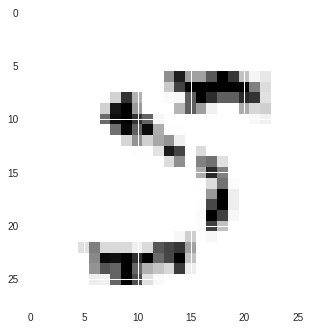

Model Outputs: ['2.16e-09', '1.83e-11', '5.83e-12', '4.33e-04', '3.40e-15', '1.00e+00', '9.15e-13', '7.67e-11', '2.19e-10', '1.69e-06']
True label:  5 predicted label: 5
N's: [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]
Epsilons: [1.0, 0.2, 0.1, 0.02, 0.01, 0.002, 0.001, 0.0002, 0.0001, 2e-05]


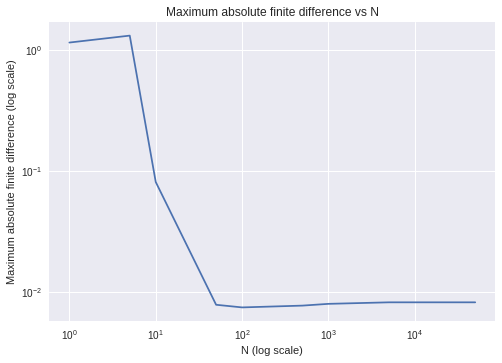

In [0]:
# example 45919 has a non-zero finite difference.
hand_picked_index = 45919

finite_gradients(nn, train_example_index=hand_picked_index, num_ns=10)


Using training Example #14283


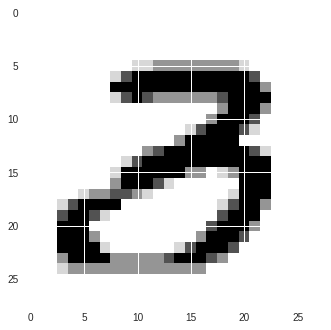

Model Outputs: ['6.96e-14', '1.12e-12', '1.31e-08', '1.00e+00', '5.08e-19', '4.54e-13', '1.67e-17', '4.53e-10', '8.62e-07', '3.69e-12']
True label:  3 predicted label: 3
N's: [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]
Epsilons: [1.0, 0.2, 0.1, 0.02, 0.01, 0.002, 0.001, 0.0002, 0.0001, 2e-05]


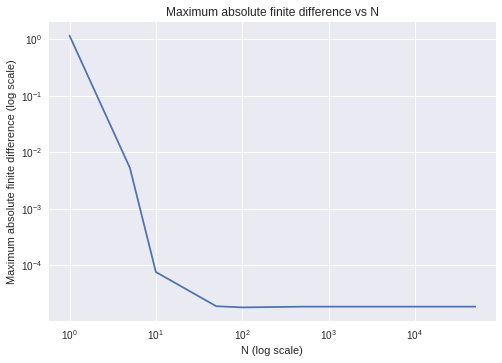

In [0]:
finite_gradients(nn, num_ns=10)


# Initialization

For this sub-question, we used 500 hidden units for the first layer and 400 for the second hidden layer. This would give us a total number for the parameters of 596,910 units. We tried 3 nonlinearities (Relu, Sigmoid and Tanh) for the neuron activation and the learning rate was 0.01. Lastly, the mini-batch size was of 32 and the weight decay (regularization) was 0. We chose these values to test the different initialization method as we knew they procurred a good accuracy (over 98% at its best) and the time needed to run 10 epochs of the entire training data was relatively small.

In [0]:
#@title Hyper-Parameter Settings
h1 = 500 #@param {type:"integer"}
h2 = 400 #@param {type:"integer"}
mini_batch_size = 32 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.03, step:0.0005}
learning_rate_decay = 0.9 #@param {type:"slider", min:0.1, max:1, step:0.05}
regularization = 0 #@param {type:"number"}

list_activations = [RELU, TANH, SIGMOID]
list_initializer = [zero_initializer, normal_initializer, glorot_initializer]

for activation in list_activations:
    for initializer in list_initializer:
        nn = evaluate_parameters(
            hidden_dims = (h1, h2),
            mini_batch_size=mini_batch_size,
            regularization=regularization,
            learning_rate=learning_rate,
            learning_rate_decay=learning_rate_decay,
            initializer = initializer,
            activation_mode = activation
        )

Hyperparameters:	hidden_dims: (500, 400)	mini_batch_size: 32	regularization: 0	learning_rate: 0.01	learning_rate_decay: 0.9	Initialization method: zero_initializer	Activation: RELU
number of trainable parameters:596910

Initialization method: zero_initializer 
Initialization method: RELU 
Training Losses: [2.3016506718936625, 2.3012729826651426, 2.3012493066120383, 2.301239942586525, 2.3012324421182724, 2.301225720671019, 2.3012195890319136, 2.3012139821137114, 2.301208858405599, 2.301204182282681]
---------------------------------------------------------------------------------------------

Hyperparameters:	hidden_dims: (500, 400)	mini_batch_size: 32	regularization: 0	learning_rate: 0.01	learning_rate_decay: 0.9	Initialization method: normal_initializer	Activation: RELU
number of trainable parameters:596910


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log



Initialization method: normal_initializer 
Initialization method: RELU 
Training Losses: [inf, 2.301268057836486, 2.301248699017619, 2.301239827403288, 2.3012324147229126, 2.3012257129966436, 2.301219586571856, 2.3012139812281758, 2.3012088580528096, 2.3012041821289855]
---------------------------------------------------------------------------------------------

Hyperparameters:	hidden_dims: (500, 400)	mini_batch_size: 32	regularization: 0	learning_rate: 0.01	learning_rate_decay: 0.9	Initialization method: glorot_initializer	Activation: RELU
number of trainable parameters:596910

Initialization method: glorot_initializer 
Initialization method: RELU 
Training Losses: [0.23186421269047516, 0.08357440543688491, 0.04939615600989196, 0.0310318662818469, 0.020281757221024817, 0.012731723371254399, 0.008831049285217617, 0.004958039986742518, 0.002672194912679811, 0.0017013316728679217]
---------------------------------------------------------------------------------------------

Hyperparam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in exp



Initialization method: normal_initializer 
Initialization method: SIGMOID 
Training Losses: [4.555646697952143, 2.0003115361535673, 1.5198531457338031, 1.3017719260788085, 1.1638549117703143, 1.0632283550137274, 0.9930880148736925, 0.9469489476873355, 0.9052384199727739, 0.865309742471509]
---------------------------------------------------------------------------------------------

Hyperparameters:	hidden_dims: (500, 400)	mini_batch_size: 32	regularization: 0	learning_rate: 0.01	learning_rate_decay: 0.9	Initialization method: glorot_initializer	Activation: SIGMOID
number of trainable parameters:596910

Initialization method: glorot_initializer 
Initialization method: SIGMOID 
Training Losses: [1.1622960385659522, 0.3690367685303147, 0.2704591840562515, 0.22132644091631642, 0.18991322802965013, 0.16650441947182193, 0.14811367443888132, 0.13382673624401345, 0.12198967688523955, 0.11113356274647125]
----------------------------------------------------------------------------------------

## Comparison of Initialization Methods

In the plots of the loss functions below, the Glorot initialization method with the ReLU activation function is the most efficient with the lowest average loss after 10 epochs of training.  

### Zero Initialization

Comparing the plots, the first thing that we noticed is that the zero initialization is the less efficient. With the ReLU and Tanh activations, the loss function does not get updated and the output is chosen at random. Despite a slight improvement, this initialization also holds poor result with the sigmoid activation. The problem is that when the weights are all initialized to zero, there is no symmetry-breaking and the weights either stay to zero or they are all updated with the same grandient. Thus, the weights keep the same value throughout the training which result in each output having the same probability regardless of the input. (This is why we would see a test accuracy of around 1/10 with the zero initialization)

### Normal Initialization

This leads us to our second observation, that the initialization following a normal distribution works decently for sigmoid and tanh. A random initialization breaks the symmetry problem that the zero-initialization faced. Consequently, the weights are updated at each step with different gradients and the output is predicted more accurately, except for the first epoch where the loss is larger since the function starts at a random point. However, some problems may arrive in the forward and back propagation when the weights are initialized at random. We notice that using the activation function ReLU. In the plot of the Cross Entropy Loss of ReLU, the loss function for the normal initialization is similar to the zero initialization. The normal initialization, unadjusted, works poorly with ReLU. Recall that ReLU = max(0, x), there is no upper bound to the value x can have when the weights grow to very large values. To avoid this problem, our softmax function is numerically stable – all the weights are shifted by their maximum value to avoid large exponents in the output layer like $e^{1000}$ which would create NaN numbers – however, instead of having NaN values at the output, some values may now vanish to 0 since all the exponents' value smaller than the max will now be negative and those too far from the maximum will tend to 0. Note that this is a design choice since dealing with zero values is easier than dealing with NaN values. 

This behavior is caused by the normal initialization having a distribution with mean 0 and variance 1. In other words, even though most weights will be between -1 and 1, a decent number of them will have values bigger than 1. This will create a problem, since each multiplication with the inputs and subsequent weight may cause the value to grow out of proportion, especially when using the ReLU activation which favor positive values. One solution would be to use very small learning rate, but this would impact the optimization of the loss function. We therefore need a weight initialization with values closer to 0. Another solution would then be to divide all the weights generated by the normal_initialization by a constant c where c is proportional to the number of hidden units. In fact, we tried this method with c > 100, which resolved most of these problems. 



### Glorot Initialization

This solution is in fact very similar to glorot_initializer where the weights are chosen in function of the numbers of units in the current and previous layers, and it leads us to our last observation. When using the glorot initialization, we noticed that the loss is lower right from the beginning in all three activations functions: ReLU, Tanh and Sigmoid. In the 3 plots, the glorot initialization clearly outperforms the two other activation functions. Also, the fact that the weights are initialized to values closer to zero remove the problem of overflowing/fading in the softmax when using ReLU activation. The values of the weights stay very low even when we sum them to the gradient (as long as the learning rate is kept relatively low; under 0.01 depending on the number of hidden units).  From our final observations, it seems that the initialization of the weights with glorot makes it easier for the gradient to reduce the loss function and to reach the global minimum faster. Therefore, we can conclude that the glorot initialization is a very robust initialization method. 

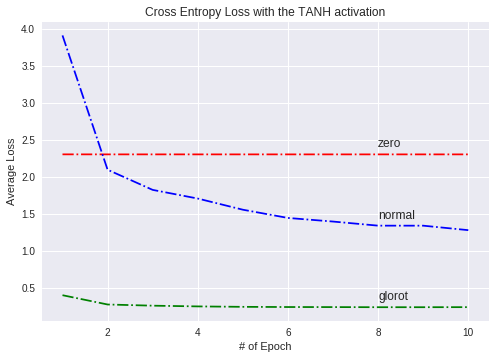

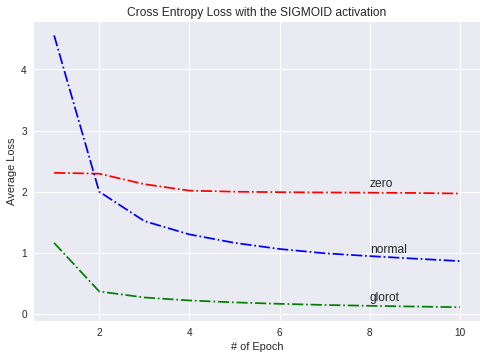

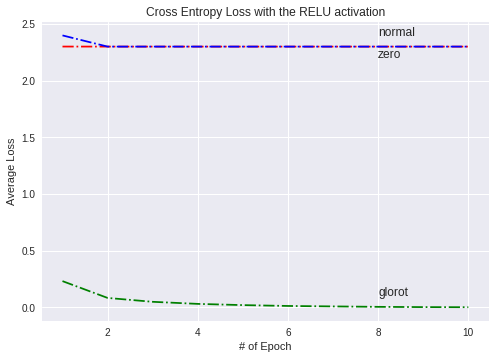

In [0]:
x = [i for i in range(1,11)]

#TANH
zero_loss = [2.3016506718936625, 2.3012729826651426, 2.3012493066120383, 2.301239942586525, 2.3012324421182724, 2.301225720671019, 
             2.3012195890319136, 2.3012139821137114, 2.301208858405599, 2.301204182282681]

normal_loss = [3.9072577078965933, 2.094063789015134, 1.8219032847883172, 1.7050504193250635, 1.5543240676426955, 1.4430821842183676, 
               1.3943942228239685, 1.338996500574805, 1.3387628708474015, 1.2781238180962222]

glorot_loss = [0.4001519432592109, 0.27469128330701453, 0.25878920415089496, 0.24888441268046615, 0.24307463780424649, 0.2404764598658431,
               0.23961035063265357, 0.23809693535480161, 0.2380441353493448, 0.23896052596473552]

plt.plot(x, zero_loss, 'r-.', x, normal_loss, 'b-.', x, glorot_loss, 'g-.')
plt.title('Cross Entropy Loss with the TANH activation')
plt.xlabel('# of Epoch')
plt.ylabel('Average Loss')
plt.text(s='zero', x = 8, y = zero_loss[7]+0.1)
plt.text(s='normal', x = 8, y = normal_loss[8]+0.1)
plt.text(s='glorot', x = 8, y = glorot_loss[9]+0.1)
plt.show()

#SIGMOID
zero_loss = [2.3088215588978946, 2.29447482521255, 2.1232423565653717, 2.0176372686523534, 1.999729723040694, 1.991989891936257, 
             1.987438310943416, 1.9835861371817831, 1.9795515453657895, 1.970971890473018]

normal_loss = [4.555646697952143, 2.0003115361535673, 1.5198531457338031, 1.3017719260788085, 1.1638549117703143, 1.0632283550137274, 
               0.9930880148736925, 0.9469489476873355, 0.9052384199727739, 0.865309742471509]

glorot_loss = [1.1622960385659522, 0.3690367685303147, 0.2704591840562515, 0.22132644091631642, 0.18991322802965013, 0.16650441947182193, 
               0.14811367443888132, 0.13382673624401345, 0.12198967688523955, 0.11113356274647125]

plt.plot(x, zero_loss, 'r-.', x, normal_loss, 'b-.', x, glorot_loss, 'g-.')
plt.title('Cross Entropy Loss with the SIGMOID activation')
plt.xlabel('# of Epoch')
plt.ylabel('Average Loss')
plt.text(s='zero', x = 8, y = zero_loss[7]+0.1)
plt.text(s='normal', x = 8, y = normal_loss[8]+0.1)
plt.text(s='glorot', x = 8, y = glorot_loss[9]+0.1)
plt.show()

#RELU
zero_loss = [2.3016506718936625, 2.3012729826651426, 2.3012493066120383, 2.301239942586525, 2.3012324421182724, 2.301225720671019, 
             2.3012195890319136, 2.3012139821137114, 2.301208858405599, 2.301204182282681]

normal_loss = [2.4, 2.301268057836486, 2.301248699017619, 2.301239827403288, 2.3012324147229126, 2.3012257129966436, 2.301219586571856, 
               2.3012139812281758, 2.3012088580528096, 2.3012041821289855]

glorot_loss = [0.23186421269047516, 0.08357440543688491, 0.04939615600989196, 0.0310318662818469, 0.020281757221024817, 0.012731723371254399, 
               0.008831049285217617, 0.004958039986742518, 0.002672194912679811, 0.0017013316728679217]

plt.plot(x, zero_loss, 'r-.', x, normal_loss, 'b-.', x, glorot_loss, 'g-.')
plt.title('Cross Entropy Loss with the RELU activation')
plt.xlabel('# of Epoch')
plt.ylabel('Average Loss')
plt.text(s='zero', x = 8, y = zero_loss[7]-0.1)
plt.text(s='normal', x = 8, y = normal_loss[8]+0.1)
plt.text(s='glorot', x = 8, y = glorot_loss[9]+0.1)
plt.show()

# Hyperparameter Search

There is an infinite number of hyperparameters we can try, therefore we will only mention the hyperparameters we thought were the most relevant. You can find an exhautive list of parameters combinations we ran in the code below.

Although plenty of hyperparameters gave us results a little above $r^{(valid)} \approx 98\text{%}$ after 10 epochs of training, we chose the following hyperparameters based on both their accuracy and the time taken to train the model. 

###Model Architecture


* Input Layer: **784 Neurons**
* First Hidden Layer ($h_1$): **500 Neurons**
* Second Hidden Layer ($h_2$): **400 Neurons**
* Output Layer: **10 Neurons**
* Mini-Batch Size: **32**

###Learning Rate

* Learning rate: **0.01**
* Learning rate decay: **0.9**
* Weight decay (regularization): **0**

###NonLinearity

* Activation function: **Rectified Linear Units (ReLU)**


\\

---
\\


For the **Model Architecture**, the parameters above gave us one of the higher $r^{(valid)}$ with $ r^{(valid)} \approx 98.20\text{%}$.

When searching for the right set of hyperparameters, we tried different combinations of number of hidden units for the first hidden layer ($h_1$) and the second hidden layer ($h_2$). Some of the sets we tried are the following:

We tried combinations where the size of $h_1$ was bigger than the input layer, but this proved to be very long to train and the result would be similar or worst than using the $h_1$ we selected. For exemple, a value of $h_1 = 900$ with the other hyperparameters similar to the one listed above would give us $r^{(valid)} \approx 97\text{%}$, but take much more time to train.

We also tried combinations where $h_2 > h_1$ such as having $h_1 = 300$ and $h_2 = 700$ but with results of $r^{(valid)} \approx 95\text{%}$, it did not seem as efficient as using $h_1 > h_2$ . Some other combinations we tried were $h_2$ close to the size of the output layer like $h_2 = 15$ or both $h_1$, $h_2$ very small. In those two cases, the results were not conclusive with $r^{(valid)} < 92\text{%}$.

In the end, using the values $200 < h_2 \leq h_1 < 700$ the model seemed to work well with a $r^{(valid)} > 96\text{%}$ and a decent training time.

Concerning the **mini-batch size**, our MLP was programmed using mini-batch SGD since it is more efficient than using stochastic gradient descent. The batch sizes we found the most conclusive varied between $8 \text{ and }32$, but when training for $10$ epochs all mini- batch sizes from $1 \text{ to } 256$ gave a decent  $r^{(valid)}$. The differences were in the training time where mini-batch sizes of $1, 2 \text{ and } 4$ took much longer to train and mini-batch sizes $> 256$ did not converge quite as fast toward the global minimum. We then chose as size of $32$ as it was a good mix between convergence and training time with a good  $r^{(valid)}$.

\\


---




\\

For the** learning rate**, we tried values from $1$ to $0.0001$. However, only values from $0.01$ to $0.003$ ended up being efficient. Bigger values like $1$ and $0.1$ would either cause the weights to grow too large or the gradients to overshoot the global minimum: the corresponding $r^{(valid)}$ would vary greatly from $10\text{%}$ to $80\text{%}$. Values under $0.001$ would be too small and the gradients, unless great luck, would be stuck in local minima with corresponding $r^{(valid)}$ varying between $80\text{% and } 92\text{%}$. Values between $0.01$ and $0.003$, depending on the mini-batch size, would produce a $r^{(valid)}$ ranging from  $95\text{% and } 98\text{%}$.

The **learning rate decay** is an hyperparameter we added to decrease the learning rate of the gradients as the training progresses. The idea is for the MLP to learn with bigger steps at the beginning to get out of local minima and converge toward the global minimum, but after multiple epochs, it has to take smaller steps to avoid overshooting the global minimum. Values between $1$ (no decay) and $0.8$ would all produce at their best $r^{(valid)} > 98\text{%}$. Therefore, while this parameter helps the model to learn more efficiently, it is not a crucial hyperparameter to this model.

The regularization using a **weight decay** was implemented in the loss function and the gradients using the L2 regularization. We chose decay values of $0, 0.01 \text{ and } 0.001$. From our tests, the best values for the weight decay was $0$ (no weight decay) and $0.001$. A weight decay of $0.01$ would reduce our optimal $r^{(valid)}$ by $2-3\text{%}$. Weight decays bigger than that would suppress our gradients even more and produce poor results.

\\


---



\\

The **nonlinearity** chosen was the ReLU function. In the Comparison of Initialization Methods section, we mentioned that ReLU was the most effective activation. The corresponding $r^{(valid)}$ of the the three activations in order were; Tanh with a result of $91-92\text{%}$; sigmoid with a result of $95-96\text{%}$; and ReLU with a result of $97-98\text{%}$.

\\


---




##Setup Code##

In [0]:
from typing import Dict, Tuple, List, Iterable
def train_function(epochs: int, number_data: int, accuracy_threshold: int, h1: int, h2: int, mini_batch_size: int, 
                   learning_rate: float, learning_rate_decay: float, regularization: float) -> Tuple[List, List, List]:
    """
    Trains a model, and returns the model and the validation accuracy.
    """
    
    nn = evaluate_parameters(
    hidden_dims = (h1, h2),
    mini_batch_size=mini_batch_size,
    regularization=regularization,
    learning_rate=learning_rate,
    learning_rate_decay=learning_rate_decay,
    initializer = glorot_initializer,
    activation_mode=RELU,
    number_epochs=epochs,
    number_data = number_data,
    accuracy_threshold = accuracy_threshold
    )
    
    return nn
    

def all_combinations_iterator(params: Dict[str, List]) -> Iterable:
    """taken from:
    https://stackoverflow.com/questions/44887695/execute-function-on-all-possible-combinations-of-parameters
    """
    import itertools
    keys = list(params)
    for values in itertools.product(*map(params.get, keys)):
        yield dict(zip(keys, values)) 

def hyperparameter_search(hyperparameters: Dict[str, List], epochs_each = 3, data_each = 60000, accuracy_threshold = 0.90) -> Tuple[Tuple, NN, float]:
    """
    Performs exhaustive parameter-search on the model with the given hyperparameters.
    """
    results = {}
    
    best_accuracy = 0
    best_model_index = -1
    best_model = None
    best_hyperparams = None
    
    hyperparameter_combinations = list(all_combinations_iterator(hyperparameters))
    
    for i in range(0,len(hyperparameter_combinations)):
        hyperparams = hyperparameter_combinations[i]
        m = train_function(epochs=epochs_each, number_data=data_each, accuracy_threshold = accuracy_threshold, **hyperparams)
        accuracy = m.accuracy
        results[tuple(hyperparams.items())] = (m, accuracy)
        
        if(i%10 == 0):
            print(f"We have done: {i} iterations")
        
        if accuracy > best_accuracy:
            print("This new combination yielded the current best model so far.")
            best_accuracy = accuracy
            best_model = m
            best_model_index = i
            best_hyperparams = hyperparams
            
        yield (best_model_index, best_accuracy*100, best_hyperparams)


##Values Used##

In [0]:
hyperparameters={
    "h1" : [700, 500],
    "h2" : [500, 400],
    "mini_batch_size" : [8,16,32],
    "learning_rate": [0.01, 0.003, 0.001],
    "learning_rate_decay": [1, 0.9, 0.8],
    "regularization":[0, 0.001, 0.01]
}

hyperparameter_combinations = list(all_combinations_iterator(hyperparameters))

num_runs = len(hyperparameter_combinations)
print("Total combinations: ", num_runs)
    

Total combinations:  324


This is an example of what the hyperparameter search would produce (you can see the complete list in the log file). The total number of combinations we tried is around $275$ since each search would take a significant amount of time to complete.

In [0]:
for result in hyperparameter_search(hyperparameters, epochs_each=5, data_each=60000, accuracy_threshold = 0.94):
    print(result,"\n")

Hyperparameters:	hidden_dims: (700, 500)	mini_batch_size: 16	regularization: 0.01	learning_rate: 0.01	learning_rate_decay: 0.9	Initialization method: glorot_initializer	Activation: RELU
number of trainable parameters:905010
Epoch: 1, Learning Rate: 1.00e-02, Training Loss:0.347, Test Loss:0.279, Test Accuracy: 94.54%
Epoch: 2, Learning Rate: 9.00e-03, Training Loss:0.228, Test Loss:0.24, Test Accuracy: 96.16%
Epoch: 3, Learning Rate: 8.10e-03, Training Loss:0.19, Test Loss:0.209, Test Accuracy: 96.70%
Epoch: 4, Learning Rate: 7.29e-03, Training Loss:0.167, Test Loss:0.226, Test Accuracy: 96.08%
Epoch: 5, Learning Rate: 6.56e-03, Training Loss:0.146, Test Loss:0.183, Test Accuracy: 97.19%
---------------------------------------------------------------------------------------------
This new combination yielded the current best model so far.
(32, 97.19, {'h1': 700, 'h2': 500, 'mini_batch_size': 16, 'learning_rate': 0.01, 'learning_rate_decay': 0.9, 'regularization': 0.01}) 

Hyperparamete